Customer Buying Behaviour

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = '/content/customer_booking.csv'

In [3]:
import chardet
with open('/content/customer_booking.csv', 'rb') as rawdata:
  result = chardet.detect(rawdata.read(100000))

print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [4]:
df= pd.read_csv(data, encoding='ISO-8859-1')

In [5]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


# Exploratory Data Analysis

In [6]:
#checking for datatypes
df.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                object
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

In [7]:
df.shape

(50000, 14)

In [8]:
#null values

df.isnull().sum()

#there is no null values

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [9]:
df.booking_complete.value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

# Mutual Information

In [10]:
X= df.drop('booking_complete',axis=1)
y= df.booking_complete         

#changing object dtype to int dtype
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [11]:
X.dtypes

num_passengers             int64
sales_channel              int64
trip_type                  int64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                      int64
booking_origin             int64
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
dtype: object

In [12]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores # show a few features with their MI scores

route                    0.053622
booking_origin           0.046275
flight_duration          0.017893
length_of_stay           0.008820
wants_extra_baggage      0.004103
wants_preferred_seat     0.003553
wants_in_flight_meals    0.003020
num_passengers           0.002602
flight_hour              0.002589
trip_type                0.001476
purchase_lead            0.000888
sales_channel            0.000307
flight_day               0.000148
Name: MI Scores, dtype: float64

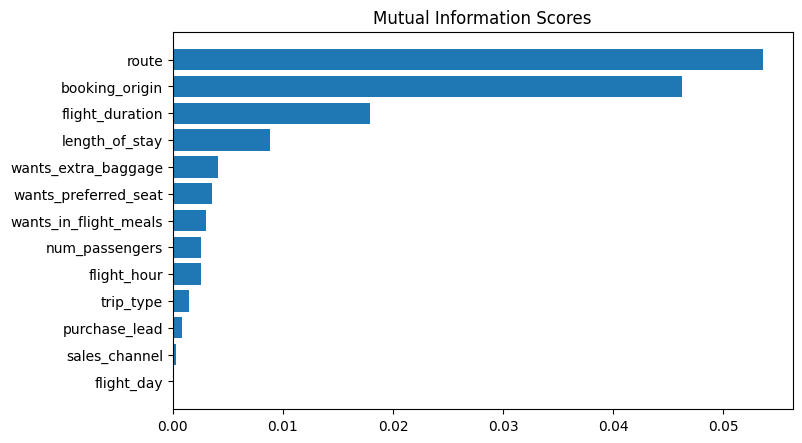

In [15]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

We can see

1.   route 
2.   booking_origin
3.   flight_duration          
4.   wants_extra_baggage      
5.   length_of_stay          

 are the top 5 features which are dependant with booking_complete feature

In [17]:
#test train split

from sklearn.model_selection import train_test_split

# dataset split
# creating a function for dataset split
def dataset(X,y):
    train_full_X, val_X, train_full_y, val_y = train_test_split(X, y,test_size=0.2,random_state = 0)

# Use the same function above for the validation set
    train_X, test_X, train_y, test_y = train_test_split(train_full_X, train_full_y, test_size=0.25,random_state = 0)
    return (train_X, val_X, train_y, val_y)

In [18]:
from sklearn.preprocessing import MinMaxScaler

def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    return X

# Model 1 : Random forest classifier with top 6 features

In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier



#assigning the features under a list

features=['route','booking_origin','flight_duration','wants_extra_baggage', 'length_of_stay','num_passengers']
X= df[features]
#one hot encoding
X = pd.get_dummies(X, columns=features)
X= scale(X)
y= df.booking_complete       

X_train,X_val,y_train,y_val= dataset(X,y)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  83.36
AUC score:  0.5657818407546988


# Model 2 : Random forest classifier with all features

In [20]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete       

X_train,X_val,y_train,y_val= dataset(X,y)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  84.76
AUC score:  0.5479604084813514


# Model 3 : XGB classifier with top 6 features

In [21]:
from xgboost import XGBClassifier

X= df[features]

#one hot encoding
X = pd.get_dummies(X, columns=features)
X= scale(X)

y= df.booking_complete    

X_train,X_val,y_train,y_val= dataset(X,y)
xgb_model = XGBClassifier()

xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)
print('ACCURACY: ',accuracy_score(y_val, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_val,prediction_xgb))

ACCURACY:  84.87
AUC score:  0.5005431112674873


# Model 4 : XGB classifier with all features

In [22]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete 

X_train,X_val,y_train,y_val= dataset(X,y)


xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)
print('ACCURACY: ',accuracy_score(y_val, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_val,prediction_xgb))

ACCURACY:  84.83000000000001
AUC score:  0.5065532363131326


Finalizing random forest model with all features as final model, as it has goos accuracy and higher auc score compared to other models

Validating with test data set

In [23]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete       

train_full_X,test_X, train_full_y, test_y = train_test_split(X, y,test_size=0.2,random_state = 0)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(train_full_X, train_full_y)
preds= forest_model.predict(test_X)

print('ACCURACY: ',accuracy_score(test_y,preds)*100)
print('AUC score: ',roc_auc_score(test_y,preds))

ACCURACY:  85.09
AUC score:  0.5577796717361984
